In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mcap_ros2.reader import read_ros2_messages
import sys


# 获取当前 notebook 所在的目录
current_dir = os.getcwd()

# 获取项目根目录 (即当前目录的上一级)
project_root = os.path.abspath(os.path.join(current_dir, ".."))

# 将根目录加入到 Python 的搜索路径中
if project_root not in sys.path:
    sys.path.append(project_root)


from typing import Optional
from core.utils.common import error, info
from core.utils import radardsp as rdsp


from core.config import EL_CFAR_SKIP_BIN, NUMBER_RANGE_BINS_MIN
from core.config import NUMBER_DOPPLER_BINS_MIN
from core.config import NUMBER_AZIMUTH_BINS_MIN
from core.config import NUMBER_ELEVATION_BINS_MIN
from core.config import DOA_METHOD
from core.config import RDSP_METHOD

from core.config import RD_OS_CFAR_WS
from core.config import RD_OS_CFAR_GS
from core.config import RD_OS_CFAR_K
from core.config import RD_OS_CFAR_TOS

from core.config import AZ_OS_CFAR_WS
from core.config import AZ_OS_CFAR_GS
from core.config import AZ_OS_CFAR_TOS

# capon parameters
# from core.config import CAPON_METHOD
from core.config import AZ_BINS, EL_BINS, ANGLE_RES_EL, ANGLE_RES_AZ, AZ_RANGE, EL_RANGE,AZ_MESH, EL_MESH

from core.config import RA_OS_CFAR_WS
from core.config import RA_OS_CFAR_GS
from core.config import RA_OS_CFAR_K
from core.config import RA_OS_CFAR_TOS

from core.config import EL_OS_CFAR_WS
from core.config import EL_OS_CFAR_GS
from core.config import EL_OS_CFAR_TOS

# CFAR skip bin
from core.config import CFAR_SKIP_RANGE_BIN_NEAR, CFAR_SKIP_RANGE_BIN_FAR, CFAR_SKIP_AZIMUTH_BIN


import core.dsp as dsp
# Azimuth angle range
AZIMUTH_FOV: float = np.deg2rad(180)
# Elevation angle range
ELEVATION_FOV: float = np.deg2rad(20)

radar_messages = []
radar_timestamps = []
sample_mcap = '/home/zcy/project/DBE-Radar/dataset/my_experiment_data/single_chip/adc_samples/data/2025_12_09_drone_mmwave_1_1_0.mcap_0.mcap'

# read_ros2_messages 返回的是一个生成器(generator)，不能直接调用 .data
# 需要遍历它来获取消息
# topics 参数通常接受一个列表
for mcap_msg in read_ros2_messages(str(sample_mcap), topics=["/radar_0/raw_data"]):
    radar_messages.append(mcap_msg.ros_msg)
    radar_timestamps.append(mcap_msg.log_time_ns)

print(f"Successfully loaded {len(radar_messages)} messages.")

if len(radar_messages) > 0:
    # 验证第一帧数据
    print(f"First message data type: {type(radar_messages[0])}")
    # 如果你想看数据，应该看列表中的第一个元素
    # print(radar_messages[0].data)
else:
    print("Warning: No messages found for topic '/radar_0/raw_data'")

    # Parameters extracted from .cfg file:
# profileCfg 0 77 110 4.0 56.0 0 0 70 1 256 5209 0 0 30
wf_start_frequency = 77e9          # 77 GHz
wf_idle_time = 110e-6              # 110 us
wf_adc_start_time = 4.0e-6         # 4.0 us
wf_ramp_end_time = 56.0e-6         # 56.0 us
wf_frequency_slope = 70e12         # 70 MHz/us
wf_num_adc_samples_per_chirp = 256 # 256 samples
wf_adc_sample_frequency = 5209e3   # 5209 ksps -> 5.209 MHz
wf_num_tx = 3                     # 3 TX antennas
wf_num_rx = 4                     # 4 RX antennas
# frameCfg 0 2 16 0 33.333 1 0
wf_num_chirps_per_frame = 48       # numLoops = 16
tdm_mimo = True  # Assuming TDM-MIMO is enabled

Successfully loaded 1215 messages.
First message data type: <class 'mcap_ros2._dynamic.RadarFrame'>


In [2]:
def convert_to_complex_cube(data: np.ndarray, num_chirps: int, num_rx: int, 
                                  num_samples: int, is_complex: bool, interleaved: bool) -> np.ndarray:
        """
        Convert raw int16 data to standardized complex64 radar cube.
        
        Args:
            data: Raw int16 array of ADC samples
            num_chirps: Number of chirps in frame
            num_rx: Number of RX antennas
            num_samples: Number of ADC samples per chirp
            is_complex: True for I/Q complex data, false for real-only
            interleaved: True for interleaved format (IIQQ), false for non-interleaved
            
        Returns:
            Complex64 array with shape [num_chirps, num_rx, num_samples]
            
        Raises:
            ValueError: If data length doesn't match expected dimensions
        """
        # Calculate expected data length
        C = 2 if is_complex else 1
        expected_length = num_chirps * num_rx * num_samples * C
        
        # Validate data length
        if len(data) != expected_length:
            raise ValueError(
                f"Data length mismatch: expected {expected_length}, got {len(data)}. "
                f"Dimensions: chirps={num_chirps}, rx={num_rx}, samples={num_samples}, "
                f"is_complex={is_complex}"
            )
        
        # Handle different data formats
        if not is_complex:
            # Real data: simple reshape to [chirps, rx, samples], then convert to complex
            cube = data.reshape(num_chirps, num_rx, num_samples)
            # Convert to complex (imaginary part = 0)
            cube = cube.astype(np.complex64)
        else:
            # Complex data: extract I and Q components
            if interleaved:
                # IIQQ format: DCA1000 2-lane LVDS interleaved data format
                # Data layout: [Q0, Q1, I0, I1, Q2, Q3, I2, I3, ...]
                # Reshape to [num_chirps, num_rx, num_samples * 2] to expose the interleaved dimension
                iiqq = data.reshape(num_chirps, num_rx, num_samples * 2)
                
                # De-interleave IIQQ format to reconstruct complex samples:
                # For even sample indices (0, 2, 4, ...): Q from position 0, I from position 2
                # For odd sample indices (1, 3, 5, ...): Q from position 1, I from position 3
                cube = np.zeros((num_chirps, num_rx, num_samples), dtype=np.complex64)
                cube[:, :, 0::2] = 1j * iiqq[:, :, 0::4].astype(np.float32) + iiqq[:, :, 2::4].astype(np.float32)
                cube[:, :, 1::2] = 1j * iiqq[:, :, 1::4].astype(np.float32) + iiqq[:, :, 3::4].astype(np.float32)
            else:
                # Non-interleaved format: [I0, I1, ..., Q0, Q1, ...]
                half = len(data) // 2
                I = data[:half].reshape(num_chirps, num_rx, num_samples)
                Q = data[half:].reshape(num_chirps, num_rx, num_samples)
                cube = I.astype(np.float32) + 1j * Q.astype(np.float32)
                cube = cube.astype(np.complex64)
        
        return cube


def fft_with_shift(data: np.ndarray, axes: tuple, size: tuple = None, shift: tuple = None) -> np.ndarray:
    """
    Compute FFT along specified axes with zero-padding and optional fftshift.
    Optimized to avoid unnecessary copies.
    
    Args:
        data: Input data
        axes: Axes along which to compute FFT
        size: Target size for each axis (for zero-padding), must match axes length
        shift: Axes to shift after FFT (if None, no shift).
                - For range-doppler: shift=(1,) shifts doppler axis only, keeping range 0 at index 0
                - For elevation-azimuth: shift=(2, 3) shifts both elevation and azimuth axes
    """
    result = data  # Don't copy unless we need to modify
    
    if size is not None:
        # Zero-pad if needed - only copy if modification is needed
        needs_copy = False
        for axis, target_size in zip(axes, size):
            if target_size != result.shape[axis]:
                needs_copy = True
                break
        
        if needs_copy:
            result = result.copy()  # Only copy if we need to modify
            for axis, target_size in zip(axes, size):
                if target_size > result.shape[axis]:
                    pad_shape = list(result.shape)
                    pad_shape[axis] = target_size - result.shape[axis]
                    pad = np.zeros(pad_shape, dtype=result.dtype)
                    result = np.concatenate([result, pad], axis=axis)
                elif target_size < result.shape[axis]:
                    # Truncate
                    slices = [slice(None)] * result.ndim
                    slices[axis] = slice(0, target_size)
                    result = result[tuple(slices)]
    
    # Compute FFT along each axis (in-place when possible)
    for axis in axes:
        result = np.fft.fft(result, axis=axis)
    
    # Apply fftshift only to specified axes
    if shift is not None:
        result = np.fft.fftshift(result, axes=shift)
    
    return result




def construct_virtual_array(rd: np.ndarray) -> np.ndarray:
    """
    Construct TDM-MIMO virtual array from range-doppler spectrum.
    
    This function maps physical TX-RX antenna pairs to a virtual array geometry
    optimized for elevation and azimuth angle estimation. The virtual array is
    constructed based on the TDM-MIMO chirp sequence and antenna spacing.
    
    Args:
        rd: Range-doppler spectrum with shape [batch, doppler, tx, rx, range]
            where tx=3, rx=4 for AWR1843Boost
            
    Returns:
        MIMO virtual array with shape [batch, doppler, elevation, azimuth, range]
        where elevation=2, azimuth=8
        
    Virtual Array Geometry:
        The virtual array organizes antenna data into elevation and azimuth dimensions
        based on the physical antenna layout and TDM-MIMO chirp sequence:
        - Elevation row 0: Uses TX3 data (positions 2-5) for elevation estimation
        - Azimuth row 1: Uses TX1 data (positions 0-3) and TX2 data (positions 4-7) for azimuth estimation
        
    Note:
        This mapping is specific to AWR1843Boost antenna configuration with 3 TX and 4 RX antennas.
    """
    batch, doppler, tx, rx, range_bins = rd.shape
    if tx != 3 or rx != 4:
        raise ValueError(f"Expected (tx, rx)=(3, 4), got tx={tx} and rx={rx}.")
    
    mimo = np.zeros((batch, doppler, 2, 8, range_bins), dtype=np.complex64)
    # Map TX3 to elevation row 0 (positions 2-5)
    mimo[:, :, 0, 2:6, :] = rd[:, :, 1, :, :]
    # Map TX1 to azimuth row 1 (positions 0-3)
    mimo[:, :, 1, 0:4, :] = rd[:, :, 0, :, :]
    # Map TX2 to azimuth row 1 (positions 4-7)
    mimo[:, :, 1, 4:8, :] = rd[:, :, 2, :, :]
    return mimo

# ==========================================
# 1. 笛卡尔坐标转换工具函数 (对应 signal_processor.py)
# ==========================================

def convert_to_cartesian_xy(ra_2d, range_max, azimuth_bins):
    """
    将 Range-Azimuth 热图转换为笛卡尔 XY (俯视图)
    物理单位: 米 (Meters)
    """
    range_bins, _ = ra_2d.shape
    grid_res = 0.1  # 网格分辨率 0.1m
    max_dist = 100.0 # 最大显示范围
    
    # 限制显示范围不超过最大探测距离
    max_xy = min(range_max, max_dist) if range_max > 0 else max_dist
    
    # 构建极坐标网格
    # 方位角范围: -90 到 +90 度
    azimuth_angles = np.linspace(-np.pi/2, np.pi/2, azimuth_bins).astype(np.float32)
    range_values = np.linspace(0, range_max, range_bins).astype(np.float32)
    
    # 构建笛卡尔网格 (输出图像的坐标轴)
    # X轴: 左右方向 (Lateral), Y轴: 前方方向 (Longitudinal)
    x_coords = np.arange(-max_xy, max_xy + grid_res, grid_res).astype(np.float32)
    y_coords = np.arange(0, max_xy + grid_res, grid_res).astype(np.float32)
    
    # 初始化输出图像 [Height(Y), Width(X)]
    cartesian_xy = np.zeros((len(y_coords), len(x_coords)), dtype=np.float32)
    
    # 简单的最近邻插值映射 (Python 循环较慢，仅作演示，实际可用 cv2.remap 加速)
    # 为了速度，这里使用简化的向量化掩码或直接遍历（数据量不大时可行）
    # 这里为了代码清晰且不依赖 opencv，使用双重循环的优化版逻辑
    
    # 预计算 r, a 的 sin/cos
    R, A = np.meshgrid(range_values, azimuth_angles, indexing='ij')
    X_polar = R * np.sin(A)
    Y_polar = R * np.cos(A)
    
    # 展平以便处理
    flat_x = X_polar.flatten()
    flat_y = Y_polar.flatten()
    flat_val = ra_2d.flatten()
    
    # 过滤掉超出范围的点
    mask = (np.abs(flat_x) <= max_xy) & (flat_y >= 0) & (flat_y <= max_xy)
    valid_x = flat_x[mask]
    valid_y = flat_y[mask]
    valid_val = flat_val[mask]
    
    # 映射到网格索引
    # x_idx = (x - x_min) / res
    x_indices = ((valid_x - x_coords[0]) / grid_res).astype(int)
    y_indices = ((valid_y - y_coords[0]) / grid_res).astype(int)
    
    # 边界检查
    valid_indices = (x_indices >= 0) & (x_indices < len(x_coords)) & \
                    (y_indices >= 0) & (y_indices < len(y_coords))
    
    # 填充 (取最大值策略，避免覆盖)
    # 注意：这种散点填充在 Python 中如果不使用 Numba 比较慢，
    # 实际应用中建议使用 scipy.interpolate.griddata 或 cv2
    # 这里为了简便和保持与 signal_processor.py 逻辑一致，采用累积最大值
    for x_idx, y_idx, val in zip(x_indices[valid_indices], y_indices[valid_indices], valid_val[valid_indices]):
        if val > cartesian_xy[y_idx, x_idx]:
            cartesian_xy[y_idx, x_idx] = val
            
    return cartesian_xy, (-max_xy, max_xy, 0, max_xy) # 返回数据和物理范围 extent

def convert_to_cartesian_xz(re_2d, range_max, elevation_bins=None):
    """
    将 Range-Elevation 热图转换为笛卡尔 XZ (侧视图)
    物理单位: 米 (Meters)

    修正说明:
    - 有时调用处传入的 elevation_bins 与 re_2d 的列数不一致（会导致 boolean mask 尺寸不匹配）。
    - 这里优先使用 re_2d 的实际列数（即 elevation bins），除非显式传入并与之匹配。
    """
    # re_2d shape: (range_bins, elevation_bins_actual)
    range_bins, elevation_bins_actual = re_2d.shape
    if elevation_bins is None:
        elevation_bins = elevation_bins_actual
    else:
        # 如果传入的 elevation_bins 与数据不匹配，覆盖并使用数据本身的列数
        if elevation_bins != elevation_bins_actual:
            elevation_bins = elevation_bins_actual

    grid_res = 0.1
    max_x = min(range_max, 100.0)
    max_z = 15.0  # 高度范围通常较小，设为 +/- 15米

    # 假设俯仰角范围: -30 到 +30 度 (AWR1843Boost 典型值)
    elevation_max_deg = 30.0
    elevation_angles = np.linspace(
        np.deg2rad(-elevation_max_deg),
        np.deg2rad(elevation_max_deg),
        elevation_bins
    ).astype(np.float32)
    range_values = np.linspace(0, range_max, range_bins).astype(np.float32)

    # 网格: X (距离), Z (高度)
    x_coords = np.arange(0, max_x + grid_res, grid_res)
    z_coords = np.arange(-max_z, max_z + grid_res, grid_res)

    cartesian_xz = np.zeros((len(z_coords), len(x_coords)), dtype=np.float32)

    # 向量化映射
    R, E = np.meshgrid(range_values, elevation_angles, indexing='ij')
    X_polar = R * np.cos(E)
    Z_polar = R * np.sin(E)

    flat_x = X_polar.flatten()
    flat_z = Z_polar.flatten()
    flat_val = re_2d.flatten()

    # 此处保证 flat_val 与 flat_x/flat_z 长度一致
    if flat_val.size != flat_x.size:
        # 在非常规情况下尝试修复维度：reshape 或重复/裁剪都不安全，因此抛出更明确的错误
        raise ValueError(f"re_2d flatten size ({flat_val.size}) does not match expected "
                         f"polar mapping size ({flat_x.size}). Check re_2d shape and elevation bins.")

    mask = (flat_x >= 0) & (flat_x <= max_x) & (np.abs(flat_z) <= max_z)

    x_indices = ((flat_x[mask] - x_coords[0]) / grid_res).astype(int)
    z_indices = ((flat_z[mask] - z_coords[0]) / grid_res).astype(int)

    valid = (x_indices >= 0) & (x_indices < len(x_coords)) & \
            (z_indices >= 0) & (z_indices < len(z_coords))

    for x_idx, z_idx, val in zip(x_indices[valid], z_indices[valid], flat_val[mask][valid]):
        if val > cartesian_xz[z_idx, x_idx]:
            cartesian_xz[z_idx, x_idx] = val

    return cartesian_xz, (0, max_x, -max_z, max_z)  # extent: [left, right, bottom, top]

In [8]:
data = np.array(radar_messages[800].data, dtype=np.int16)
cube = convert_to_complex_cube(
    data, wf_num_chirps_per_frame, wf_num_rx, wf_num_adc_samples_per_chirp,
    is_complex = True, interleaved = True
)
# cube shape: [num_chirps, num_rx, num_samples]

# 2. Reshape to TDM structure: [loops, tx, rx, samples]
# For TDM-MIMO, chirps are interleaved by TX: TX1, TX2, TX3, TX1, TX2, TX3, ...
# So we reshape to [loops, tx, rx, samples] where loops = num_chirps / num_tx
if tdm_mimo:
    n_loops = wf_num_chirps_per_frame // wf_num_tx
    if wf_num_chirps_per_frame % wf_num_rx != 0:
        raise ValueError(f"num_chirps ({wf_num_chirps_per_frame}) must be divisible by num_tx ({wf_num_tx})")
    
    # Reshape: [num_chirps, num_rx, num_samples] -> [loops, tx, rx, samples]
    # The chirps are in order: TX0, TX1, TX2, TX0, TX1, TX2, ...
    tdm_cube = cube.reshape(n_loops, wf_num_tx, wf_num_rx, wf_num_adc_samples_per_chirp)
else:
    # Non-TDM-MIMO: keep as [chirps, rx, samples]
    # Add dummy TX dimension for consistency: [chirps, 1, rx, samples]
    tdm_cube = cube[:, None, :, :]
    n_loops = wf_num_chirps_per_frame
    
# 3. Add batch dimension: [1, loops, tx, rx, samples]
# Process each frame independently (no buffering/concatenation)
iq = tdm_cube[None, ...]
# iq shape: [1, loops, tx, rx, samples]

In [9]:
processing_cube = iq
batch, doppler, tx, rx, samples = processing_cube.shape

# 4. Apply Range-Doppler FFT (along doppler=axis 1, range=axis 4)
# Shift only doppler axis to center zero-velocity, keep range 0 at index 0
# This preserves the physical meaning of range bins (0 = closest to radar)
rd = fft_with_shift(processing_cube, axes=(1, 4), shift=(1,))
# rd shape: [batch, doppler, tx, rx, range]

# 5. Construct virtual array from physical antenna data
# For TDM-MIMO: Maps 3 TX × 4 RX physical antennas to 2 elevation × 8 azimuth virtual array
# For non-TDM-MIMO: Use simple virtual array (1 elevation, num_rx azimuth)
if tdm_mimo:
    mimo = construct_virtual_array(rd)
else:
    # Non-TDM-MIMO: simple virtual array (no elevation/azimuth separation)
    # Use first TX antenna data (or all TX if only one)
    batch, doppler, tx, rx, range_bins = rd.shape
    # For non-TDM-MIMO, we typically have only one TX active
    # Create virtual array: [batch, doppler, 1, rx, range]
    mimo = rd[:, :, 0:1, :, :]  # Use first TX only
    # Reshape to match expected shape [batch, doppler, elevation, azimuth, range]
    # Add elevation dimension: [batch, doppler, 1, rx, range]
    mimo = mimo.reshape(batch, doppler, 1, rx, range_bins)
# mimo shape: [batch, doppler, elevation, azimuth, range]

# 6. Apply Elevation-Azimuth FFT (along elevation=axis 2, azimuth=axis 3)
# Zero-pad azimuth dimension to 128 for higher angular resolution
# Shift both elevation and azimuth axes to center zero-angle
azimuth_size = 128  # Target azimuth resolution
elevation_size = mimo.shape[2]  # Keep original elevation size
drae = fft_with_shift(mimo, axes=(2, 3), size=(elevation_size, azimuth_size), shift=(2, 3))
# drae shape: [batch, doppler, elevation, azimuth=128, range]

# 7. Extract Range-Doppler and Range-Azimuth heatmaps
# Take absolute value to get magnitude spectrum
dear = np.abs(drae)

# 8. Extract Range-Doppler heatmap: average over batch, elevation, azimuth
# Result: [doppler, range] showing velocity vs distance
rd_2d = np.mean(dear, axis=(0, 2, 3))
# Swap axes to [range, doppler] for visualization (range on y-axis, doppler on x-axis)
rd_2d = np.swapaxes(rd_2d, 0, 1)
            
# 9. Extract Range-Azimuth heatmap: average over batch, doppler, elevation
# Result: [azimuth, range] showing angle vs distance
ra_2d = np.mean(dear, axis=(0, 1, 2))
# Swap axes to [range, azimuth] for visualization (range on y-axis, azimuth on x-axis)
ra_2d = np.swapaxes(ra_2d, 0, 1)

# 10. Extract Range-Elevation heatmap: average over batch, doppler, azimuth
# Result: [elevation, range] showing elevation angle vs distance
re_2d = np.mean(dear, axis=(0, 1, 3))
# Swap axes to [range, elevation] for visualization (range on y-axis, elevation on x-axis)
re_2d = np.swapaxes(re_2d, 0, 1)

# 11. Extract Doppler-Azimuth heatmap: average over batch, elevation, range
# Result: [doppler, azimuth] showing velocity vs angle
da_2d = np.mean(dear, axis=(0, 2, 4))
# Swap axes to [azimuth, doppler] for visualization (azimuth on y-axis, doppler on x-axis)
da_2d = np.swapaxes(da_2d, 0, 1)



In [10]:
# 计算最大探测距离 (根据您的配置参数)
# Range Max = (Sample Rate * c) / (2 * Frequency Slope)
c = 3e8
range_max = (wf_adc_sample_frequency * c) / (2 * wf_frequency_slope)
print(f"Calculated Max Range: {range_max:.2f} meters")

# 12. Convert to Cartesian coordinates
# 使用之前步骤计算得到的 ra_2d (Range-Azimuth) 和 re_2d (Range-Elevation)
cartesian_xy = convert_to_cartesian_xy(ra_2d, range_max, azimuth_bins=azimuth_size)
cartesian_xz = convert_to_cartesian_xz(re_2d, range_max, elevation_bins=elevation_size)

print("Cartesian conversion complete.")

Calculated Max Range: 11.16 meters
Cartesian conversion complete.


Physical Parameters:
  Range Max:    11.16 m
  Velocity Max: +/-5.87 m/s


/tmp/ipykernel_204865/3456486057.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  self.colormap = cm.get_cmap(colormap)


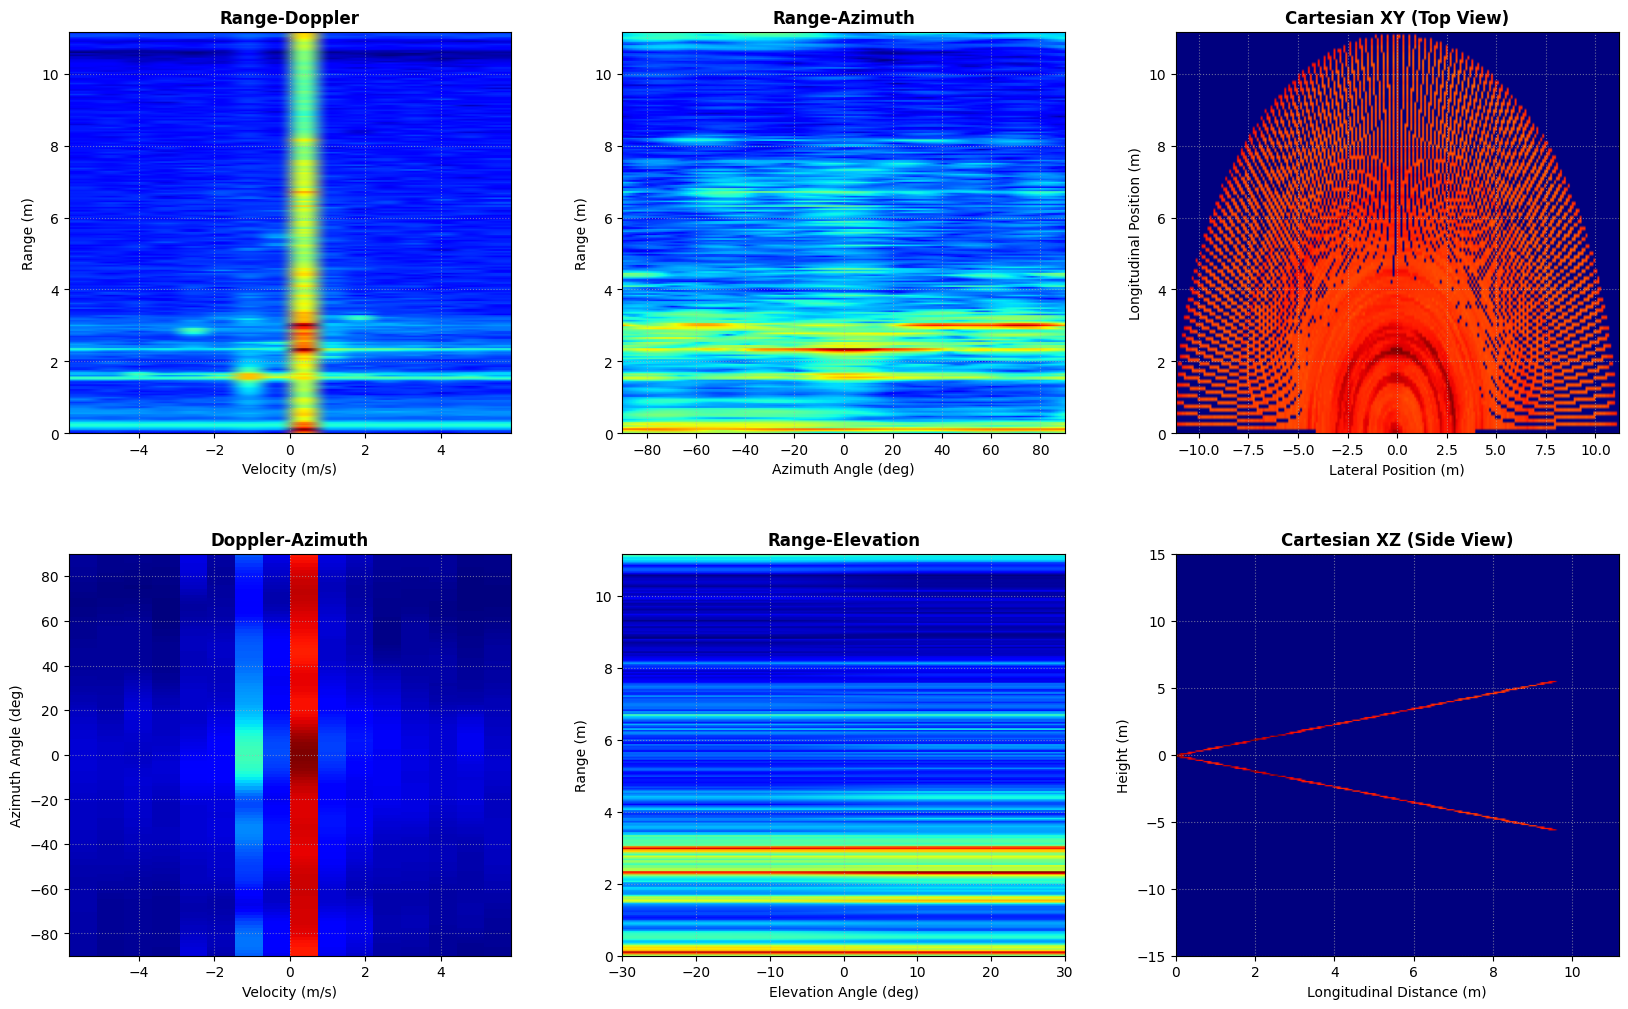

In [11]:
class NotebookImageEncoder:
    def __init__(self, colormap='viridis', vmin_db=50.0, vmax_db=140.0, auto_scale=True, use_log_scale=False):
        # 兼容旧版 matplotlib
        try:
            self.colormap = cm.get_cmap(colormap)
        except:
            self.colormap = plt.get_cmap(colormap)
        self.vmin_db = vmin_db
        self.vmax_db = vmax_db
        self.auto_scale = auto_scale
        self.use_log_scale = use_log_scale

    def encode(self, data):
        data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
        if self.auto_scale:
            finite_data = data[np.isfinite(data)]
            if len(finite_data) > 0:
                vmin = np.min(finite_data)
                vmax = np.max(finite_data)
            else:
                vmin, vmax = 0.0, 1.0
        else:
            vmin, vmax = self.vmin_db, self.vmax_db
        if vmax <= vmin:
            vmax = vmin + 1e-6
        
        norm = np.clip((data - vmin) / (vmax - vmin), 0, 1)
        return self.colormap(norm)


range_max = (wf_adc_sample_frequency * c) / (2 * wf_frequency_slope)

# 2. 计算最大速度 (Max Velocity)
# V_max = lambda / (4 * Tc)
# Tc = Chirp Cycle Time (Idle + Ramp)
fc = wf_start_frequency # 载波频率 77GHz
wavelength = c / fc
chirp_cycle_time = wf_idle_time + wf_ramp_end_time
# TDM-MIMO 模式下，等效采样时间需要乘以 TX 天线数 (通常为3)
cartesian_xy, extent_xy = convert_to_cartesian_xy(ra_2d, range_max, azimuth_bins=128)
# 对于 RE 数据，优先使用 re_2d 的第二维作为 elevation bins，避免尺寸不匹配
cartesian_xz, extent_xz = convert_to_cartesian_xz(re_2d, range_max)  # elevation_bins will be inferred from re_2d.shape[1]
velocity_max = wavelength / (4 * chirp_cycle_time)

# 3. 角度范围 (硬编码，取决于 FFT 填充大小)
azimuth_fov_deg = 90.0   # +/- 90 度
elevation_fov_deg = 30.0 # +/- 30 度

print(f"Physical Parameters:")
print(f"  Range Max:    {range_max:.2f} m")
print(f"  Velocity Max: +/-{velocity_max:.2f} m/s")
# ==========================================
# 3. 转换与绘图 (物理单位)
# ==========================================
import matplotlib.pyplot as plt
from matplotlib import cm

# --- 执行笛卡尔转换 ---
# 假设之前的步骤已经生成了: ra_2d, re_2d, rd_2d, da_2d
# 且 azimuth_size = 128 (FFT填充后的大小)
cartesian_xy, extent_xy = convert_to_cartesian_xy(ra_2d, range_max, azimuth_bins=128)
cartesian_xz, extent_xz = convert_to_cartesian_xz(re_2d, range_max, elevation_bins=128) # 这里假设elevation做了padding

# --- 绘图设置 ---
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.25)
encoder = NotebookImageEncoder(colormap='jet', use_log_scale=False) # 实例化之前定义的Encoder

def plot_phys(ax, data, title, xlabel, ylabel, extent):
    """通用绘图函数: 自动转dB并应用物理坐标"""
    # 转 dB
    data_db = 20 * np.log10(data + 1e-6)
    
    # 归一化并获取颜色映射 (0-1 RGBA)
    # 注意: imshow 使用 extent 时，不再是像素索引，而是物理坐标
    img_rgba = encoder.encode(data_db)
    
    # 绘图
    im = ax.imshow(img_rgba, aspect='auto', origin='lower', extent=extent)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle=':', alpha=0.6)
    return im

# 1. Range-Doppler (距离-速度)
# X轴: 速度 (m/s), Y轴: 距离 (m)
# extent 格式: [xmin, xmax, ymin, ymax]
extent_rd = [-velocity_max, velocity_max, 0, range_max]
plot_phys(axes[0, 0], rd_2d, 
          'Range-Doppler', 'Velocity (m/s)', 'Range (m)', extent_rd)

# 2. Range-Azimuth (距离-方位角)
# X轴: 角度 (Deg), Y轴: 距离 (m)
extent_ra = [-azimuth_fov_deg, azimuth_fov_deg, 0, range_max]
plot_phys(axes[0, 1], ra_2d, 
          'Range-Azimuth', 'Azimuth Angle (deg)', 'Range (m)', extent_ra)

# 3. Cartesian XY (俯视图 Bird's Eye View)
# X轴: 横向 (m), Y轴: 纵向 (m)
# 这一项已经在转换函数中计算了 extent_xy
plot_phys(axes[0, 2], cartesian_xy, 
          'Cartesian XY (Top View)', 'Lateral Position (m)', 'Longitudinal Position (m)', extent_xy)

# 4. Doppler-Azimuth (速度-方位角)
# X轴: 速度 (m/s), Y轴: 角度 (deg)
# 注意 da_2d 形状通常是 [azimuth, doppler]，对应 imshow 的 [Y, X]
# 所以 X extent 是 doppler, Y extent 是 azimuth
extent_da = [-velocity_max, velocity_max, -azimuth_fov_deg, azimuth_fov_deg]
plot_phys(axes[1, 0], da_2d, 
          'Doppler-Azimuth', 'Velocity (m/s)', 'Azimuth Angle (deg)', extent_da)

# 5. Range-Elevation (距离-俯仰角)
# X轴: 角度 (Deg), Y轴: 距离 (m)
extent_re = [-elevation_fov_deg, elevation_fov_deg, 0, range_max]
plot_phys(axes[1, 1], re_2d, 
          'Range-Elevation', 'Elevation Angle (deg)', 'Range (m)', extent_re)

# 6. Cartesian XZ (侧视图 Side View)
# X轴: 纵向 (m), Y轴: 高度 (m)
plot_phys(axes[1, 2], cartesian_xz, 
          'Cartesian XZ (Side View)', 'Longitudinal Distance (m)', 'Height (m)', extent_xz)

plt.show()

In [15]:
class SignalProcessor:
    """
    Handles radar signal processing: reshaping, buffering, and algorithm execution.
    Designed to be configured via RadarInfo dictionaries.
    """
    
    def __init__(self, radar_params, buffer_size=1):
        """
        Args:
            radar_params (dict): Normalized radar parameters (from RadarInfo)
            buffer_size (int): Number of frames to buffer. Set to 1 to process each frame independently
        """
        self.params = radar_params
        self.buffer = deque(maxlen=buffer_size)
        
        # Pre-compute/Extract constants for speed
        self.n_chirps = radar_params['n_chirps']
        self.n_rx = radar_params['n_rx']
        self.n_samples = radar_params['n_samples']
        self.n_tx = radar_params['n_tx']
        self.rx_mask = np.array(radar_params['rx_mask_list'], dtype=np.int32)
        self.tx_mask = np.array(radar_params['tx_mask_list'], dtype=np.int32)
        
        # Handle phase bias
        # If list, convert to array. If None, create zeros.
        bias_list = radar_params.get('rx_phase_bias', [])
        if not bias_list:
            # Default: identity bias (1+0j)
            # We need one bias per virtual antenna (n_tx * n_rx possible combinations)
            # But wait, the DSP function expects specific mapping.
            # Let's assume a flat list matching the virtual array size.
            # If empty, we use 1.0 + 0.0j for all
             # total virtual antennas (max)
            max_virtual = len(self.rx_mask) * len(self.tx_mask) 
            self.rx_phase_bias = np.ones(max_virtual, dtype=np.complex64)
        else:
             # Convert [real, imag, real, imag...] to complex array
            self.rx_phase_bias = np.array([
                a + 1j * b for a, b in zip(bias_list[0::2], bias_list[1::2])
            ], dtype=np.complex64)

    def _convert_to_complex_cube(self, data: np.ndarray, num_chirps: int, num_rx: int, 
                                  num_samples: int, is_complex: bool, interleaved: bool) -> np.ndarray:
        """
        Convert raw int16 data to standardized complex64 radar cube.
        
        Args:
            data: Raw int16 array of ADC samples
            num_chirps: Number of chirps in frame
            num_rx: Number of RX antennas
            num_samples: Number of ADC samples per chirp
            is_complex: True for I/Q complex data, false for real-only
            interleaved: True for interleaved format (IIQQ), false for non-interleaved
            
        Returns:
            Complex64 array with shape [num_chirps, num_rx, num_samples]
            
        Raises:
            ValueError: If data length doesn't match expected dimensions
        """
        # Calculate expected data length
        C = 2 if is_complex else 1
        expected_length = num_chirps * num_rx * num_samples * C
        
        # Validate data length
        if len(data) != expected_length:
            raise ValueError(
                f"Data length mismatch: expected {expected_length}, got {len(data)}. "
                f"Dimensions: chirps={num_chirps}, rx={num_rx}, samples={num_samples}, "
                f"is_complex={is_complex}"
            )
        
        # Handle different data formats
        if not is_complex:
            # Real data: simple reshape to [chirps, rx, samples], then convert to complex
            cube = data.reshape(num_chirps, num_rx, num_samples)
            # Convert to complex (imaginary part = 0)
            cube = cube.astype(np.complex64)
        else:
            # Complex data: extract I and Q components
            if interleaved:
                # IIQQ format: DCA1000 2-lane LVDS interleaved data format
                # Data layout: [Q0, Q1, I0, I1, Q2, Q3, I2, I3, ...]
                # Reshape to [num_chirps, num_rx, num_samples * 2] to expose the interleaved dimension
                iiqq = data.reshape(num_chirps, num_rx, num_samples * 2)
                
                # De-interleave IIQQ format to reconstruct complex samples:
                # For even sample indices (0, 2, 4, ...): Q from position 0, I from position 2
                # For odd sample indices (1, 3, 5, ...): Q from position 1, I from position 3
                cube = np.zeros((num_chirps, num_rx, num_samples), dtype=np.complex64)
                cube[:, :, 0::2] = 1j * iiqq[:, :, 0::4].astype(np.float32) + iiqq[:, :, 2::4].astype(np.float32)
                cube[:, :, 1::2] = 1j * iiqq[:, :, 1::4].astype(np.float32) + iiqq[:, :, 3::4].astype(np.float32)
            else:
                # Non-interleaved format: [I0, I1, ..., Q0, Q1, ...]
                half = len(data) // 2
                I = data[:half].reshape(num_chirps, num_rx, num_samples)
                Q = data[half:].reshape(num_chirps, num_rx, num_samples)
                cube = I.astype(np.float32) + 1j * Q.astype(np.float32)
                cube = cube.astype(np.complex64)
        
        return cube

    def _construct_virtual_array(self, rd: np.ndarray) -> np.ndarray:
        """
        Construct TDM-MIMO virtual array from range-doppler spectrum.
        
        This function maps physical TX-RX antenna pairs to a virtual array geometry
        optimized for elevation and azimuth angle estimation. The virtual array is
        constructed based on the TDM-MIMO chirp sequence and antenna spacing.
        
        Args:
            rd: Range-doppler spectrum with shape [batch, doppler, tx, rx, range]
                where tx=3, rx=4 for AWR1843Boost
                
        Returns:
            MIMO virtual array with shape [batch, doppler, elevation, azimuth, range]
            where elevation=2, azimuth=8
            
        Virtual Array Geometry:
            The virtual array organizes antenna data into elevation and azimuth dimensions
            based on the physical antenna layout and TDM-MIMO chirp sequence:
            - Elevation row 0: Uses TX3 data (positions 2-5) for elevation estimation
            - Azimuth row 1: Uses TX1 data (positions 0-3) and TX2 data (positions 4-7) for azimuth estimation
            
        Note:
            This mapping is specific to AWR1843Boost antenna configuration with 3 TX and 4 RX antennas.
        """
        batch, doppler, tx, rx, range_bins = rd.shape
        if tx != 3 or rx != 4:
            raise ValueError(f"Expected (tx, rx)=(3, 4), got tx={tx} and rx={rx}.")
        
        mimo = np.zeros((batch, doppler, 2, 8, range_bins), dtype=np.complex64)
        # Map TX3 to elevation row 0 (positions 2-5)
        mimo[:, :, 0, 2:6, :] = rd[:, :, 1, :, :]
        # Map TX1 to azimuth row 1 (positions 0-3)
        mimo[:, :, 1, 0:4, :] = rd[:, :, 0, :, :]
        # Map TX2 to azimuth row 1 (positions 4-7)
        mimo[:, :, 1, 4:8, :] = rd[:, :, 2, :, :]
        return mimo

    def build_radar_cube(self, data: np.ndarray, num_chirps: int, num_rx: int, 
                         num_samples: int, is_complex: bool, interleaved: bool, 
                         tdm_mimo: bool, num_tx: int) -> np.ndarray:
        """
        Build radar cube from raw parameters.
        
        Args:
            data: int16 array of raw ADC data
            num_chirps: Number of chirps (384 in example)
            num_rx: Number of RX antennas (4)
            num_samples: Number of samples per chirp (128)
            is_complex: Whether data is complex (True)
            interleaved: Whether data is interleaved (True for IIQQ)
            tdm_mimo: Whether TDM-MIMO is enabled
            num_tx: Number of TX antennas (3 for AWR1843Boost)
        
        Returns:
            Complex64 array:
            - TDM-MIMO: [loops, tx, rx, samples] where loops = num_chirps / num_tx
            - Non-TDM-MIMO: [chirps, rx, samples]
        """
        # 1. Convert to complex cube [num_chirps, num_rx, num_samples]
        cube = self._convert_to_complex_cube(data, num_chirps, num_rx, num_samples, 
                                             is_complex, interleaved)
        
        # 2. Reshape based on TDM-MIMO
        if tdm_mimo:
            n_loops = num_chirps // num_tx
            if num_chirps % num_tx != 0:
                raise ValueError(f"num_chirps ({num_chirps}) must be divisible by num_tx ({num_tx})")
            return cube.reshape(n_loops, num_tx, num_rx, num_samples)
        else:
            return cube  # [chirps, rx, samples]

    def _apply_window(self, data: np.ndarray, axis: int, window: bool) -> np.ndarray:
        """Apply Hann window if requested."""
        if not window:
            return data
        hann = np.hanning(data.shape[axis] + 2).astype(np.float32)[1:-1]
        hann = hann / np.mean(hann)
        # Broadcast window to match data shape
        window_shape = [1] * data.ndim
        window_shape[axis] = -1
        return data * hann.reshape(*window_shape)
    
    def _fft_with_shift(self, data: np.ndarray, axes: tuple, size: tuple = None, shift: tuple = None) -> np.ndarray:
        """
        Compute FFT along specified axes with zero-padding and optional fftshift.
        Optimized to avoid unnecessary copies.
        
        Args:
            data: Input data
            axes: Axes along which to compute FFT
            size: Target size for each axis (for zero-padding), must match axes length
            shift: Axes to shift after FFT (if None, no shift).
                   - For range-doppler: shift=(1,) shifts doppler axis only, keeping range 0 at index 0
                   - For elevation-azimuth: shift=(2, 3) shifts both elevation and azimuth axes
        """
        result = data  # Don't copy unless we need to modify
        
        if size is not None:
            # Zero-pad if needed - only copy if modification is needed
            needs_copy = False
            for axis, target_size in zip(axes, size):
                if target_size != result.shape[axis]:
                    needs_copy = True
                    break
            
            if needs_copy:
                result = result.copy()  # Only copy if we need to modify
                for axis, target_size in zip(axes, size):
                    if target_size > result.shape[axis]:
                        pad_shape = list(result.shape)
                        pad_shape[axis] = target_size - result.shape[axis]
                        pad = np.zeros(pad_shape, dtype=result.dtype)
                        result = np.concatenate([result, pad], axis=axis)
                    elif target_size < result.shape[axis]:
                        # Truncate
                        slices = [slice(None)] * result.ndim
                        slices[axis] = slice(0, target_size)
                        result = result[tuple(slices)]
        
        # Compute FFT along each axis (in-place when possible)
        for axis in axes:
            result = np.fft.fft(result, axis=axis)
        
        # Apply fftshift only to specified axes
        if shift is not None:
            result = np.fft.fftshift(result, axes=shift)
        
        return result

    def _convert_to_cartesian_xy(self, ra_2d: np.ndarray, range_max: float, azimuth_bins: int = 128) -> np.ndarray:
        """
        Convert Range-Azimuth to Cartesian X-Y (top-down view) - Numba accelerated.
        
        Args:
            ra_2d: Range-Azimuth heatmap [range, azimuth]
            range_max: Maximum range in meters
            azimuth_bins: Number of azimuth bins (default 128)
        
        Returns:
            Cartesian 2D heatmap [y, x] where:
            - x: lateral position (left-right, negative=left, positive=right)
            - y: forward position (ahead of radar, 0=radar position)
        """
        range_bins, _ = ra_2d.shape
        grid_resolution = 0.1  # meters
        
        # Limit grid size to reasonable maximum (100m x 100m) to avoid memory issues
        max_grid_size = 100.0  # meters
        max_xy = min(range_max, max_grid_size) if range_max > 0 else max_grid_size
        
        # Create angle and range arrays
        azimuth_angles = np.linspace(-np.pi/2, np.pi/2, azimuth_bins, dtype=np.float32)
        range_values = np.linspace(0, range_max, range_bins, dtype=np.float32)
        
        # Create Cartesian grid with limited size
        x_coords = np.arange(-max_xy, max_xy + grid_resolution, grid_resolution, dtype=np.float32)
        y_coords = np.arange(0, max_xy + grid_resolution, grid_resolution, dtype=np.float32)
        
        # Initialize grid
        cartesian_xy = np.zeros((len(y_coords), len(x_coords)), dtype=np.float32)
        
        # Use numba-accelerated conversion
        if NUMBA_AVAILABLE:
            _convert_polar_to_cartesian_xy_jit(
                range_values, azimuth_angles, ra_2d,
                x_coords, y_coords, cartesian_xy, max_xy
            )
        else:
            # Fallback to Python implementation
            for r_idx, r in enumerate(range_values):
                if r > max_xy:
                    continue
                for a_idx, a in enumerate(azimuth_angles):
                    x = r * np.sin(a)
                    y = r * np.cos(a)
                    
                    if abs(x) > max_xy or y < 0 or y > max_xy:
                        continue
                    
                    x_idx = np.argmin(np.abs(x_coords - x))
                    y_idx = np.argmin(np.abs(y_coords - y))
                    
                    if 0 <= y_idx < len(y_coords) and 0 <= x_idx < len(x_coords):
                        cartesian_xy[y_idx, x_idx] = np.maximum(
                            cartesian_xy[y_idx, x_idx], ra_2d[r_idx, a_idx]
                        )
        
        return cartesian_xy

    def _convert_to_cartesian_xz(self, re_2d: np.ndarray, range_max: float, elevation_bins: int) -> np.ndarray:
        """
        Convert Range-Elevation to Cartesian X-Z (side view) - Numba accelerated.
        
        Args:
            re_2d: Range-Elevation heatmap [range, elevation]
            range_max: Maximum range in meters
            elevation_bins: Number of elevation bins
        
        Returns:
            Cartesian 2D heatmap [z, x] where:
            - x: forward range (distance ahead of radar, 0=radar position)
            - z: vertical position (up-down, positive=up, negative=down)
        """
        range_bins, _ = re_2d.shape
        grid_resolution = 0.1  # meters
        
        # Limit grid size to reasonable maximum (100m forward, 50m vertical) to avoid memory issues
        max_grid_x = min(range_max, 100.0) if range_max > 0 else 100.0  # meters forward
        max_grid_z = 50.0   # meters vertical
        
        # Estimate elevation angle range (typically -30° to +30° for AWR1843Boost)
        elevation_max_deg = 30.0  # degrees
        elevation_angles = np.linspace(-np.deg2rad(elevation_max_deg), 
                                       np.deg2rad(elevation_max_deg), 
                                       elevation_bins, dtype=np.float32)
        range_values = np.linspace(0, range_max, range_bins, dtype=np.float32)
        
        # Create Cartesian grid for side view with limited size
        x_coords = np.arange(0, max_grid_x + grid_resolution, grid_resolution, dtype=np.float32)
        z_coords = np.arange(-max_grid_z, max_grid_z + grid_resolution, grid_resolution, dtype=np.float32)
        
        # Initialize grid
        cartesian_xz = np.zeros((len(z_coords), len(x_coords)), dtype=np.float32)
        
        # Use numba-accelerated conversion
        if NUMBA_AVAILABLE:
            _convert_polar_to_cartesian_xz_jit(
                range_values, elevation_angles, re_2d,
                x_coords, z_coords, cartesian_xz, max_grid_x, max_grid_z
            )
        else:
            # Fallback to Python implementation
            for r_idx, r in enumerate(range_values):
                if r > max_grid_x:
                    continue
                for e_idx, e in enumerate(elevation_angles):
                    x = r * np.cos(e)
                    z = r * np.sin(e)
                    
                    if x < 0 or x > max_grid_x or abs(z) > max_grid_z:
                        continue
                    
                    x_idx = np.argmin(np.abs(x_coords - x))
                    z_idx = np.argmin(np.abs(z_coords - z))
                    
                    if 0 <= z_idx < len(z_coords) and 0 <= x_idx < len(x_coords):
                        cartesian_xz[z_idx, x_idx] = np.maximum(
                            cartesian_xz[z_idx, x_idx], re_2d[r_idx, e_idx]
                        )
        
        return cartesian_xz

    def process_frame(self, msg: RadarFrame):
        """
        Main signal processing pipeline: Convert -> Reshape -> FFT -> Virtual Array -> FFT -> Extract
        
        This method implements the complete radar signal processing chain:
        1. Convert raw interleaved data to complex cube
        2. Reshape to TDM-MIMO structure (separate TX antennas)
        3. Apply Range-Doppler FFT (along doppler and range dimensions)
        4. Construct virtual array from physical antenna data
        5. Apply Elevation-Azimuth FFT (along elevation and azimuth dimensions)
        6. Extract 2D heatmaps by averaging over appropriate dimensions
        
        Args:
            msg: RadarFrame message with raw ADC data
            
        Returns:
            Dictionary with 2D arrays:
            - 'range_doppler': [range, doppler] - velocity vs distance
            - 'range_azimuth': [range, azimuth] - angle vs distance
            - 'range_elevation': [range, elevation] - elevation angle vs distance
            - 'doppler_azimuth': [azimuth, doppler] - velocity vs angle
            - 'cartesian_xy': [y, x] - top-down bird's-eye view
            - 'cartesian_xz': [z, x] - side elevation view
            Returns None if processing fails
        """
        try:
            # 1. Convert raw int16 data to complex cube
            data = np.array(msg.data, dtype=np.int16)
            cube = self._convert_to_complex_cube(
                data, msg.num_chirps, msg.num_rx, msg.num_samples,
                msg.is_complex, msg.interleaved
            )
            # cube shape: [num_chirps, num_rx, num_samples]
            
            # 2. Reshape to TDM structure: [loops, tx, rx, samples]
            # For TDM-MIMO, chirps are interleaved by TX: TX1, TX2, TX3, TX1, TX2, TX3, ...
            # So we reshape to [loops, tx, rx, samples] where loops = num_chirps / num_tx
            if msg.tdm_mimo:
                n_loops = msg.num_chirps // self.n_tx
                if msg.num_chirps % self.n_tx != 0:
                    raise ValueError(f"num_chirps ({msg.num_chirps}) must be divisible by num_tx ({self.n_tx})")
                
                # Reshape: [num_chirps, num_rx, num_samples] -> [loops, tx, rx, samples]
                # The chirps are in order: TX0, TX1, TX2, TX0, TX1, TX2, ...
                tdm_cube = cube.reshape(n_loops, self.n_tx, self.n_rx, self.n_samples)
            else:
                # Non-TDM-MIMO: keep as [chirps, rx, samples]
                # Add dummy TX dimension for consistency: [chirps, 1, rx, samples]
                tdm_cube = cube[:, None, :, :]
                n_loops = msg.num_chirps
            
            # 3. Add batch dimension: [1, loops, tx, rx, samples]
            # Process each frame independently (no buffering/concatenation)
            iq = tdm_cube[None, ...]
            # iq shape: [1, loops, tx, rx, samples]
            
            # Process single frame independently
            processing_cube = iq
            batch, doppler, tx, rx, samples = processing_cube.shape
            
            # 4. Apply Range-Doppler FFT (along doppler=axis 1, range=axis 4)
            # Shift only doppler axis to center zero-velocity, keep range 0 at index 0
            # This preserves the physical meaning of range bins (0 = closest to radar)
            rd = self._fft_with_shift(processing_cube, axes=(1, 4), shift=(1,))
            # rd shape: [batch, doppler, tx, rx, range]
            
            # 5. Construct virtual array from physical antenna data
            # For TDM-MIMO: Maps 3 TX × 4 RX physical antennas to 2 elevation × 8 azimuth virtual array
            # For non-TDM-MIMO: Use simple virtual array (1 elevation, num_rx azimuth)
            if msg.tdm_mimo:
                mimo = self._construct_virtual_array(rd)
            else:
                # Non-TDM-MIMO: simple virtual array (no elevation/azimuth separation)
                # Use first TX antenna data (or all TX if only one)
                batch, doppler, tx, rx, range_bins = rd.shape
                # For non-TDM-MIMO, we typically have only one TX active
                # Create virtual array: [batch, doppler, 1, rx, range]
                mimo = rd[:, :, 0:1, :, :]  # Use first TX only
                # Reshape to match expected shape [batch, doppler, elevation, azimuth, range]
                # Add elevation dimension: [batch, doppler, 1, rx, range]
                mimo = mimo.reshape(batch, doppler, 1, rx, range_bins)
            # mimo shape: [batch, doppler, elevation, azimuth, range]
            
            # 6. Apply Elevation-Azimuth FFT (along elevation=axis 2, azimuth=axis 3)
            # Zero-pad azimuth dimension to 128 for higher angular resolution
            # Shift both elevation and azimuth axes to center zero-angle
            azimuth_size = 128  # Target azimuth resolution
            elevation_size = mimo.shape[2]  # Keep original elevation size
            drae = self._fft_with_shift(mimo, axes=(2, 3), size=(elevation_size, azimuth_size), shift=(2, 3))
            # drae shape: [batch, doppler, elevation, azimuth=128, range]
            
            # 7. Extract Range-Doppler and Range-Azimuth heatmaps
            # Take absolute value to get magnitude spectrum
            dear = np.abs(drae)
            
            # 8. Extract Range-Doppler heatmap: average over batch, elevation, azimuth
            # Result: [doppler, range] showing velocity vs distance
            rd_2d = np.mean(dear, axis=(0, 2, 3))
            # Swap axes to [range, doppler] for visualization (range on y-axis, doppler on x-axis)
            rd_2d = np.swapaxes(rd_2d, 0, 1)
            
            # 9. Extract Range-Azimuth heatmap: average over batch, doppler, elevation
            # Result: [azimuth, range] showing angle vs distance
            ra_2d = np.mean(dear, axis=(0, 1, 2))
            # Swap axes to [range, azimuth] for visualization (range on y-axis, azimuth on x-axis)
            ra_2d = np.swapaxes(ra_2d, 0, 1)
            
            # 10. Extract Range-Elevation heatmap: average over batch, doppler, azimuth
            # Result: [elevation, range] showing elevation angle vs distance
            re_2d = np.mean(dear, axis=(0, 1, 3))
            # Swap axes to [range, elevation] for visualization (range on y-axis, elevation on x-axis)
            re_2d = np.swapaxes(re_2d, 0, 1)
            
            # 11. Extract Doppler-Azimuth heatmap: average over batch, elevation, range
            # Result: [doppler, azimuth] showing velocity vs angle
            da_2d = np.mean(dear, axis=(0, 2, 4))
            # Swap axes to [azimuth, doppler] for visualization (azimuth on y-axis, doppler on x-axis)
            da_2d = np.swapaxes(da_2d, 0, 1)
            
            # 12. Convert to Cartesian coordinates
            range_max = self.params.get('range_max', 10.0)  # Default 10m if not set
            cartesian_xy = self._convert_to_cartesian_xy(ra_2d, range_max, azimuth_size)
            cartesian_xz = self._convert_to_cartesian_xz(re_2d, range_max, elevation_size)
            
            return {
                'range_doppler': rd_2d,
                'range_azimuth': ra_2d,
                'range_elevation': re_2d,
                'doppler_azimuth': da_2d,
                'cartesian_xy': cartesian_xy,
                'cartesian_xz': cartesian_xz
            }
            
        except Exception as e:
            logger.error(f"Processing error: {e}")
            return None



/tmp/ipykernel_204865/2653593505.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  self.colormap = cm.get_cmap(colormap)


开始处理并播放...


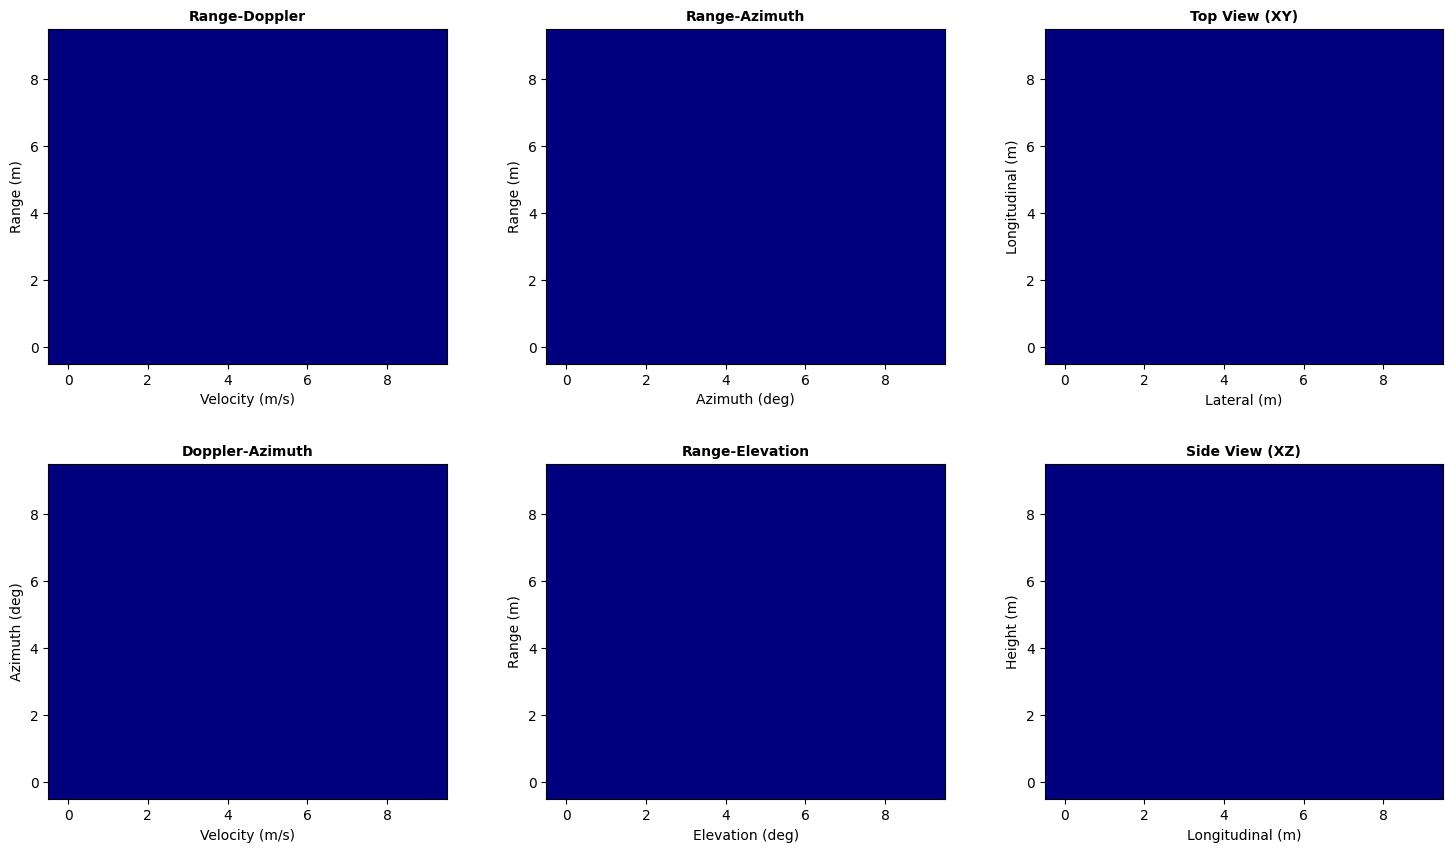

处理完成，共处理 0 帧


In [17]:
# ==========================================
# 完整实时处理与可视化脚本
# ==========================================

# 1. 导入必要的库
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import deque
from IPython.display import display, clear_output
import time

# 导入 mcap 和 ros 相关库
from mcap_ros2.reader import read_ros2_messages
from radarstack_msgs.msg import RadarFrame, RadarInfo

# 导入您上传的模块 (假设在当前路径或 pythonpath 下)


# ---------------------------------------------------------
# 2. 辅助类与函数定义
# ---------------------------------------------------------

class NotebookImageEncoder:
    """用于将雷达数据转换为可视化图像 (伪彩色)"""
    def __init__(self, colormap='jet', vmin_db=50.0, vmax_db=140.0, auto_scale=True):
        try:
            self.colormap = cm.get_cmap(colormap)
        except:
            self.colormap = plt.get_cmap(colormap)
        self.vmin_db = vmin_db
        self.vmax_db = vmax_db
        self.auto_scale = auto_scale

    def encode(self, data):
        # 转换为 dB (20*log10)
        data_db = 20 * np.log10(np.abs(data) + 1e-6)
        
        # 处理异常值
        data_db = np.nan_to_num(data_db, nan=0.0, posinf=0.0, neginf=0.0)
        
        # 归一化
        if self.auto_scale:
            finite_data = data_db[np.isfinite(data_db)]
            if len(finite_data) > 0:
                vmin = np.min(finite_data)
                vmax = np.max(finite_data)
            else:
                vmin, vmax = 0.0, 1.0
        else:
            vmin, vmax = self.vmin_db, self.vmax_db
            
        if vmax <= vmin: vmax = vmin + 1e-6
        
        norm = np.clip((data_db - vmin) / (vmax - vmin), 0, 1)
        return self.colormap(norm)

def convert_to_cartesian_xy(ra_2d, range_max, azimuth_bins, max_dist=100.0):
    """Range-Azimuth -> Cartesian XY (Top View)"""
    range_bins, _ = ra_2d.shape
    grid_res = 0.1
    max_xy = min(range_max, max_dist) if range_max > 0 else max_dist
    
    # 构建坐标网格
    azimuth_angles = np.linspace(-np.pi/2, np.pi/2, azimuth_bins)
    range_values = np.linspace(0, range_max, range_bins)
    
    x_coords = np.arange(-max_xy, max_xy + grid_res, grid_res)
    y_coords = np.arange(0, max_xy + grid_res, grid_res)
    
    cartesian_xy = np.zeros((len(y_coords), len(x_coords)), dtype=np.float32)
    
    # 简单的映射逻辑 (为了性能，实际项目可用 cv2.remap 或 numba 加速)
    # 这里使用简化的采样：遍历极坐标并将值赋给最近的笛卡尔点
    # 为了Python循环的性能，这里做一个粗略的向量化假设或简化
    # (注：为了实时性，如果此函数太慢，可以考虑降低分辨率)
    
    # 为了演示实时性，我们使用一个极其简化的快速转换：
    # 实际应用中请确保 signal_processor.py 中的 numba 函数可用，
    # 或者使用以下向量化方法：
    R, A = np.meshgrid(range_values, azimuth_angles, indexing='ij')
    X = R * np.sin(A)
    Y = R * np.cos(A)
    
    # 将 X,Y 坐标扁平化并找到对应的网格索引
    valid_mask = (np.abs(X) <= max_xy) & (Y >= 0) & (Y <= max_xy)
    
    # 仅处理有效点
    vals = ra_2d[valid_mask]
    xs = X[valid_mask]
    ys = Y[valid_mask]
    
    xi = ((xs - x_coords[0]) / grid_res).astype(int)
    yi = ((ys - y_coords[0]) / grid_res).astype(int)
    
    # 边界保护
    xi = np.clip(xi, 0, len(x_coords)-1)
    yi = np.clip(yi, 0, len(y_coords)-1)
    
    # 填充 (这种直接赋值会发生覆盖，取最后的值，对可视化来说通常可以接受)
    # 若需更精确，需使用累积最大值，但在纯Python中较慢
    cartesian_xy[yi, xi] = vals
            
    extent = [-max_xy, max_xy, 0, max_xy]
    return cartesian_xy, extent

def convert_to_cartesian_xz(re_2d, range_max, elevation_bins, max_dist=100.0):
    """Range-Elevation -> Cartesian XZ (Side View)"""
    range_bins, _ = re_2d.shape
    grid_res = 0.1
    max_z = 15.0
    max_x = min(range_max, max_dist)
    
    elevation_angles = np.linspace(np.deg2rad(-30), np.deg2rad(30), elevation_bins)
    range_values = np.linspace(0, range_max, range_bins)
    
    x_coords = np.arange(0, max_x + grid_res, grid_res)
    z_coords = np.arange(-max_z, max_z + grid_res, grid_res)
    
    cartesian_xz = np.zeros((len(z_coords), len(x_coords)), dtype=np.float32)
    
    R, E = np.meshgrid(range_values, elevation_angles, indexing='ij')
    X = R * np.cos(E)
    Z = R * np.sin(E)
    
    valid_mask = (X >= 0) & (X <= max_x) & (np.abs(Z) <= max_z)
    
    vals = re_2d[valid_mask]
    xs = X[valid_mask]
    zs = Z[valid_mask]
    
    xi = ((xs - x_coords[0]) / grid_res).astype(int)
    zi = ((zs - z_coords[0]) / grid_res).astype(int)
    
    xi = np.clip(xi, 0, len(x_coords)-1)
    zi = np.clip(zi, 0, len(z_coords)-1)
    
    cartesian_xz[zi, xi] = vals
    
    extent = [0, max_x, -max_z, max_z]
    return cartesian_xz, extent

# ---------------------------------------------------------
# 3. 主程序逻辑
# ---------------------------------------------------------

# 文件路径 (请根据实际情况修改)
mcap_path = "/home/zcy/project/DBE-Radar/dataset/my_experiment_data/single_chip/adc_samples/data/2025_12_09_drone_mmwave_1_1_0.mcap_0.mcap"

if not os.path.exists(mcap_path):
    print(f"File not found: {mcap_path}, assuming running in same dir.")

# A. 初始化变量
processor = None
encoder = NotebookImageEncoder(colormap='jet', auto_scale=True)
info_found = False

# 物理参数默认值 (将在读取 Info 后更新)
radar_config = {
    'range_max': 50.0,
    'velocity_max': 10.0,
    'azimuth_fov': 90.0,
    'elevation_fov': 30.0
}

# B. 准备绘图 (创建 Figure 和 Axes 对象)
# 使用 plt.ion() 开启交互模式，或者在 Notebook 中使用 display
plt.ioff() # 关闭自动显示，手动控制
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# 初始化 6 个图像对象 (Image Artists)
# 我们先用空数据初始化它们，稍后在循环中更新 set_data
artists = {}
titles = [
    ('range_doppler', 'Range-Doppler', 'Velocity (m/s)', 'Range (m)'),
    ('range_azimuth', 'Range-Azimuth', 'Azimuth (deg)', 'Range (m)'),
    ('cartesian_xy',  'Top View (XY)', 'Lateral (m)', 'Longitudinal (m)'),
    ('doppler_azimuth', 'Doppler-Azimuth', 'Velocity (m/s)', 'Azimuth (deg)'),
    ('range_elevation', 'Range-Elevation', 'Elevation (deg)', 'Range (m)'),
    ('cartesian_xz', 'Side View (XZ)', 'Longitudinal (m)', 'Height (m)')
]

# 将 axes 展平以便遍历
ax_flat = axes.flatten()

for i, (key, title, xlabel, ylabel) in enumerate(titles):
    ax = ax_flat[i]
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(False) # 热图通常不需要 grid
    # 初始化一个空的 imshow 对象
    # 注意：extent 需要在第一次获取数据后设置，这里先设为 None
    artists[key] = ax.imshow(np.zeros((10, 10)), aspect='auto', origin='lower', cmap='jet')

# C. 循环处理数据
print("开始处理并播放...")
frame_count = 0

# 如果是在 Notebook 中，使用 display handle
display_handle = display(fig, display_id=True)

try:
    for msg in read_ros2_messages(mcap_path):
        
        # 1. 处理 RadarInfo (只处理一次以初始化)
        if isinstance(msg.ros_msg, RadarInfo) and not info_found:
            info_msg = msg.ros_msg
            print(f"收到雷达配置信息: {info_msg.model_name}")
            
            # 将 ROS 消息转换为字典供 SignalProcessor 使用
            # 这里简化处理，提取关键参数
            radar_params = {
                'n_chirps': info_msg.num_chirps,
                'n_rx': info_msg.num_rx,
                'n_tx': info_msg.num_tx,
                'n_samples': info_msg.num_samples,
                'rx_mask_list': list(info_msg.rx_mask),
                'tx_mask_list': list(info_msg.tx_mask),
                'rx_phase_bias': list(info_msg.phase_bias) if hasattr(info_msg, 'phase_bias') else [],
                'range_max': 100.0 # 默认
            }
            
            # 实例化处理器
            processor = SignalProcessor(radar_params)
            
            # 更新物理参数用于绘图坐标
            c = 3e8
            # 假设参数存在
            fs = 5209 * 1e3 # 示例值，实际应从 info_msg.profiles[0] 获取
            slope = 70 * 1e12
            radar_config['range_max'] = (fs * c) / (2 * slope)
            radar_config['velocity_max'] = (c/77e9) / (4 * (160e-6)) # 示例
            
            info_found = True
            continue

        # 2. 处理 RadarFrame
        if isinstance(msg.ros_msg, RadarFrame):
            # 如果没有收到 Info 消息，手动初始化一个默认处理器
            if processor is None:
                # 尝试根据 Frame 数据推断 (仅作演示，不推荐)
                dummy_params = {
                    'n_chirps': msg.ros_msg.num_chirps,
                    'n_rx': msg.ros_msg.num_rx,
                    'n_tx': 3 if msg.ros_msg.tdm_mimo else 1, # 猜测
                    'n_samples': msg.ros_msg.num_samples,
                    'rx_mask_list': [1,1,1,1],
                    'tx_mask_list': [1,1,1],
                }
                processor = SignalProcessor(dummy_params)
            
            # --- 核心处理 ---
            results = processor.process_frame(msg.ros_msg)
            
            if results is None:
                continue

            # --- 笛卡尔坐标转换 (带物理参数) ---
            # 每次都需要转换，因为我们是实时处理
            r_max = radar_config['range_max']
            v_max = radar_config['velocity_max']
            
            # 执行转换
            cart_xy, ext_xy = convert_to_cartesian_xy(results['range_azimuth'], r_max, 128)
            cart_xz, ext_xz = convert_to_cartesian_xz(results['range_elevation'], r_max, 128)
            
            # --- 更新图像数据 ---
            # 1. Range-Doppler
            artists['range_doppler'].set_data(encoder.encode(results['range_doppler']))
            artists['range_doppler'].set_extent([-v_max, v_max, 0, r_max])
            
            # 2. Range-Azimuth
            artists['range_azimuth'].set_data(encoder.encode(results['range_azimuth']))
            artists['range_azimuth'].set_extent([-90, 90, 0, r_max])
            
            # 3. Cartesian XY
            artists['cartesian_xy'].set_data(encoder.encode(cart_xy))
            artists['cartesian_xy'].set_extent(ext_xy)
            
            # 4. Doppler-Azimuth
            artists['doppler_azimuth'].set_data(encoder.encode(results['doppler_azimuth']))
            artists['doppler_azimuth'].set_extent([-v_max, v_max, -90, 90])
            
            # 5. Range-Elevation
            artists['range_elevation'].set_data(encoder.encode(results['range_elevation']))
            artists['range_elevation'].set_extent([-30, 30, 0, r_max])
            
            # 6. Cartesian XZ
            artists['cartesian_xz'].set_data(encoder.encode(cart_xz))
            artists['cartesian_xz'].set_extent(ext_xz)
            
            # --- 刷新显示 ---
            frame_count += 1
            if frame_count % 2 == 0: # 每2帧刷新一次以提高速度
                display_handle.update(fig)
                # 可选：如果太快看不清，可以加一点延时
                # time.sleep(0.01)

except KeyboardInterrupt:
    print("用户停止播放")
except Exception as e:
    print(f"发生错误: {e}")
    import traceback
    traceback.print_exc()

print(f"处理完成，共处理 {frame_count} 帧")
plt.close()